# Number 2: Spatial Joins (Mapping NYC Art Galleries)

You have two datasets:

* A shapefile of New York City neighborhoods, unzipped into `nynta_14d/`
* A csv of art galleries in New York City, called `galleries.csv`

We're going to count the art galleries in each neighborhood, then create a choropleth map of the results.

**MAKE SURE YOU HAVE COMPLETED PART ONE BEFORE YOU DO THIS ONE.**

## Part Zero: Importing what you need

Probably pandas, geopandas, a bit of matplotlib magic to make your graphics show up in the notebook, maybe some other stuff..

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

## Part One: Opening your datasets

**Open up both files!** I won't give you a long-winded explanation since I gave you one last time.

In [2]:
neighborhoods = gpd.read_file('nynta_14d/nynta.shp')
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((998870.8071899414 168503.1193847656,..."
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((1000351.30279541 194574.900390625, 9..."
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((1014295.119384766 253236.9890136719,..."
3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((990897.9002075195 169268.1207885742,..."
4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((1009623.354003906 176865.7595825195,..."


In [40]:
df = pd.read_csv('galleries.csv')
df['geometry'] = df.apply(lambda row: Point(row.longitude, row.latitude), axis=1)
galleries = gpd.GeoDataFrame(df, geometry='geometry')
galleries.crs = {'init': 'epsg:4326'}
galleries.head()

,name,tel,url,addr1,addr2,city,zip,longitude,latitude,geometry
0,O'reilly William & Co Ltd,(212) 396-1822,http://www.nyc.com/arts__attractions/oreilly_w...,52 E 76th St,NaN,New York,10021,-73.962731,40.773801,POINT (-73.96273075000001 40.77380087)
1,Organization of Independent Artists - Gallery 402,(212) 219-9213,http://www.nonprofitgallery.com/main/usa/ny/oi...,19 Hudson St.,NaN,New York,10013,-74.009386,40.716469,POINT (-74.00938579 40.71646851)
2,Owen Gallery,(212) 879-2415,http://www.owengallery.com/about-us,19 E 75th St,NaN,New York,10021,-73.964352,40.774001,POINT (-73.96435178 40.77400085)
3,P P O W Gallerie,(212) 647-1044,http://www.ppowgallery.com/,511 W 25th St,NaN,New York,10001,-74.003893,40.749585,POINT (-74.00389260999999 40.7495854)
4,P P O W Inc,(212) 941-8642,http://www.nyc.com/arts__attractions/p_p_o_w_i...,476 Broome St,NaN,New York,10013,-74.001764,40.722907,POINT (-74.00176390000001 40.72290743)


## Part Two: Converting your data

In order to spatially join the data, they need to be in the same crs. Just like we did last time, set the CRS of the neighborhood map to be the same as the galleries. Use `.head()` to make sure the switch worked.

(**Note:** If you want to update the dataframe permanently, you'll need to do `your_dataframe = your_dataframe.to_crs(...whatever...)`. Otherwise it won't keep the change on record.)

In [41]:
neighborhoods = neighborhoods.to_crs(galleries.crs)

In [42]:
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,0
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...,0
3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1
4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522767 40.65209593779451...,0


Confirm that you converted correctly by mapping to see if they're on top of one another.

(-74.283370478149223,
 -73.672229948213371,
 40.47514452610185,
 40.936503645568806)

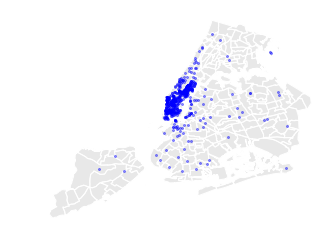

In [43]:
ax = neighborhoods.plot(color='lightgrey', edgecolor='white')
galleries.plot(color='blue', alpha=0.4, ax=ax)
ax.axis('off')

## Part Three: Assigning neighborhoods to galleries

So now we have some galleries (points), and we have some neighborhoods (shapes), and we'd like to **see which neighborhood each gallery is in**. The end result will be a dataframe of galleries with a column that says which neighborhood it's in.

We're going to take the columns from the neighborhood that matches, and wham! add them right to the gallery.

To do this we're going to use a [spatial join](http://geopandas.org/mergingdata.html#spatial-joins). You do a spatial join by using `gpd.sjoin` along with a few parameters.

```gpd.sjoin(dataset1, dataset2, how='...', op='...')```

* **`dataset1`** is a GeoDataFrame - the one whose geography you WANT to keep
* **`dataset2`** is a GeoDataFrame - the one whose geography you're giving up
* **`how`** is the join type - it can be left, right, outer or inner. 
* **`op`** is the operation to say how the merge technically works: Should dataset 1 be inside of dataset 2? Dataset 1 be surrounding dataset 2? Do you just want any sort of intersection? This is the `op` parameter, and can be `within`, `contains`, or `intersects`.

So now ask yourself these questions and get to work:

1. **Pick which dataset you give `sjoin` first:** Do you want neighborhoods with galleries or galleries with neighborhoods?
2. **What do you want to do with geographies that don't have any matches?** `left` to keep them anyway, `inner` to get rid of them.
3. **What kind of geographic match do you want?** This is usually a tougher question when doing shapes vs. shapes

Once you've tried your join, scroll to the right to make sure each gallery has a `BoroName`, `NTAName`, etc.

In [44]:
galleries_with_neighborhoods = gpd.sjoin(galleries, neighborhoods, how='left', op='within')

In [45]:
galleries_with_neighborhoods.head()

,name,tel,url,addr1,addr2,city,zip,longitude,latitude,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,gallery_count
0,O'reilly William & Co Ltd,(212) 396-1822,http://www.nyc.com/arts__attractions/oreilly_w...,52 E 76th St,NaN,New York,10021,-73.962731,40.773801,POINT (-73.96273075000001 40.77380087),26,1,Manhattan,061,MN40,Upper East Side-Carnegie Hill,2.006533e+07,23778.406402,153
1,Organization of Independent Artists - Gallery 402,(212) 219-9213,http://www.nonprofitgallery.com/main/usa/ny/oi...,19 Hudson St.,NaN,New York,10013,-74.009386,40.716469,POINT (-74.00938579 40.71646851),87,1,Manhattan,061,MN24,SoHo-TriBeCa-Civic Center-Little Italy,2.485957e+07,24284.700443,116
2,Owen Gallery,(212) 879-2415,http://www.owengallery.com/about-us,19 E 75th St,NaN,New York,10021,-73.964352,40.774001,POINT (-73.96435178 40.77400085),26,1,Manhattan,061,MN40,Upper East Side-Carnegie Hill,2.006533e+07,23778.406402,153
3,P P O W Gallerie,(212) 647-1044,http://www.ppowgallery.com/,511 W 25th St,NaN,New York,10001,-74.003893,40.749585,POINT (-74.00389260999999 40.7495854),180,1,Manhattan,061,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,3.702973e+07,45454.722802,208
4,P P O W Inc,(212) 941-8642,http://www.nyc.com/arts__attractions/p_p_o_w_i...,476 Broome St,NaN,New York,10013,-74.001764,40.722907,POINT (-74.00176390000001 40.72290743),87,1,Manhattan,061,MN24,SoHo-TriBeCa-Civic Center-Little Italy,2.485957e+07,24284.700443,116


## Part Four: Using the new neighborhood info

List out all of the galleries in the **East Village**.

In [46]:
galleries_with_neighborhoods[galleries_with_neighborhoods.NTAName == 'East Village']

,name,tel,url,addr1,addr2,city,zip,longitude,latitude,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,gallery_count
5,P S 122 Gallery,(212) 228-4249,http://ps122gallery.org/,150 1st Ave,NaN,New York,10009,-73.984371,40.728168,POINT (-73.98437147999999 40.72816774),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
127,Savacou Galleries,(212) 473-6904,http://www.artchain.com/cgi-bin/showorganizati...,240 E 13th St,NaN,New York,10003,-73.986268,40.731782,POINT (-73.98626836 40.73178218),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
221,Three East Third St Corp,(212) 533-7749,http://ny.citysquares.com/manhattan/east-villa...,3 E 3rd St,NaN,New York,10003,-73.991270,40.726317,POINT (-73.99127036 40.72631717),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
265,Washington Sq Outdoor Art Exhibit Inc,(212) 982-6255,http://www.washingtonsquareoutdoorartexhibit.org/,115 E 9th St,NaN,New York,10003,-73.989560,40.730554,POINT (-73.98955957 40.73055351),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
279,Willow Woodstock Artistic Enterprises,(212) 677-6547,http://www.yelp.com/biz/willow-woodstock-artis...,92 Saint Marks Pl,NaN,New York,10009,-73.985038,40.727318,POINT (-73.98503774 40.72731799),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
453,Bodanna Inc,(212) 388-0078,http://www.merchantcircle.com/business/Bodanna...,123 E 7th St,NaN,New York,10009,-73.984120,40.726527,POINT (-73.98411975 40.72652721),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
454,Bolivar Arellano Gallery,(212) 420-1263,http://www.bolivararellanogallery.com/,420 E 9th St,NaN,New York,10009,-73.983916,40.727612,POINT (-73.98391617999999 40.72761183),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
461,Bridgewater Gallery of Fine Arts Inc,(212) 674-3650,http://www.bwfinearts.com/,176 East 3rd Street,Suite 5G,New York,10009,-73.984126,40.722926,POINT (-73.98412586000001 40.72292592),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
797,Goethe-Institut Wyoming Building,212-439-8700,http://www.goethe.de/Ins/Us/ney/prj/wyo/eninde...,5 East 3rd Street,NaN,New York,10003,-73.991119,40.726343,POINT (-73.99111875 40.72634319),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11
827,Mansion Gracie Gallery,(212) 505-7055,http://www.artnet.com/graciemansion.html,101 Second Avenue,#1,New York,10003,-73.988869,40.727408,POINT (-73.98886924 40.72740796),52,1,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,11


Cool, now **count how many galleries are in each neighborhood**

In [48]:
galleries_with_neighborhoods.NTAName.value_counts()

Hudson Yards-Chelsea-Flatiron-Union Square          208
Upper East Side-Carnegie Hill                       153
SoHo-TriBeCa-Civic Center-Little Italy              116
Midtown-Midtown South                               107
West Village                                         42
Lenox Hill-Roosevelt Island                          29
Turtle Bay-East Midtown                              28
Upper West Side                                      18
Chinatown                                            17
Murray Hill-Kips Bay                                 14
Battery Park City-Lower Manhattan                    13
Yorkville                                            12
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill     11
East Village                                         11
North Side-South Side                                11
Lincoln Square                                       10
Clinton                                              10
Lower East Side                                 

## Part Five: Counting points in polygons

I mean, we could just use `.plot()`...

(-8269186.976035662,
 -8201155.1234400729,
 4907479.0192146711,
 4974966.8995483425)

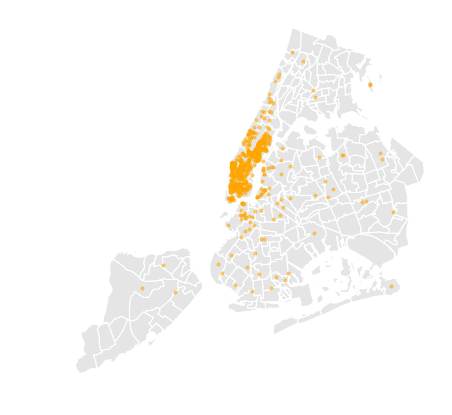

In [8]:
ax = neighborhoods.to_crs({'proj': 'merc'}).plot(color='#cccccc', edgecolor='white', figsize=(7,7))
galleries.to_crs({'proj': 'merc'}).plot(ax=ax, color='orange', markersize=3, alpha=0.5)
ax.axis('off')

Life would be nicer if we had a [choropleth](https://en.wikipedia.org/wiki/Choropleth_map) that would show us darker spots where there were more galleries and lighter colors where there were fewer.

You might think "Oh, yes, **let's do a spatial join!**" which is right but a little conceptually difficult at a couple points. There's another way to do it, too, but it's a bit slower and less flexible, but easier to understand. Maybe read through both of them to see if one works better in your brain than the other.

## COUNTING POINTS METHOD ONE: Spatial join

Before we do the actual join, I'm going to show you a little trick called `.reset_index()`. It seems dumb and useless now, but it'll save us a while later, **allowing us to push aggregate statistics (counts, medians, etc) back onto your original dataframes after a spatial join.**

Let's use it!

In [50]:
# Run this cell!
neighborhoods.reset_index().head()

,index,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,0
1,1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1
2,2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...,0
3,3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1
4,4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522767 40.65209593779451...,0


See how **`index`** is now a column? It's going to be helpful later!

**Let's get to work now:** We're going to do a spatial join of neighborhoods to galleries (throwing away any neighborhoods that don't have galleries) and then counting how many times each neighborhood shows up. Then we'll take that value and put it right back into our neighborhoods dataframe.

In [51]:
# Do an INNER join, so that neighborhoods without galleries get dumped
# We're doing .reset_index() to be sure that 'index' shows up in our joined dataset
nabes_with_galleries = gpd.sjoin(neighborhoods.reset_index(), galleries, how='inner', op='intersects')
nabes_with_galleries.head(10)

,index,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count,index_right,name,tel,url,addr1,addr2,city,zip,longitude,latitude
1,1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1,304,2 Welancora Gallery,(718) 919-0344,http://www.welancora.com/,410 Jefferson Ave,NaN,Brooklyn,11221,-73.941520,40.684078
3,3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1,43,Plaster Palace,(718) 621-3175,http://www.merchantcircle.com/business/Plaster...,5305 18th Ave,NaN,Brooklyn,11204,-73.983150,40.625760
7,7,3,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257341,POLYGON ((-73.93753749374042 40.60855739025753...,1,153,Shulman B & M Inc,(718) 646-6022,http://brooklyn.citysearch.com/profile/6018933...,2623 Avenue U,NaN,Brooklyn,11229,-73.945065,40.600274
11,11,4,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712110,POLYGON ((-73.86109724401754 40.76366447759027...,1,116,Sabrina Enterprise.Com Artworks Sales and Rprd...,(718) 335-5088,http://www.nyc.com/arts__attractions/sabrina_e...,10022 32nd Ave,NaN,East Elmhurst,11369,-73.867907,40.759059
14,14,3,Brooklyn,047,BK41,Kensington-Ocean Parkway,1.589335e+07,20800.556075,POLYGON ((-73.97482741755579 40.64566342086809...,1,317,AAA-Abbey Mdsng Co Inc,(718) 253-8830,http://yp.blogflux.com/directory/us/new-york/b...,618 Coney Island Ave,NaN,Brooklyn,11218,-73.969931,40.642238
19,19,3,Brooklyn,047,BK46,Ocean Parkway South,1.778203e+07,21975.997984,POLYGON ((-73.96285973961456 40.61254948646702...,1,623,Judaica Illuminations,(718) 375-4600,http://www.judaicailluminations.com/,1664 Coney Island Ave,NaN,Brooklyn,11230,-73.963959,40.616776
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,327,Adelson Galleries,(212) 439-6800,http://www.adelsongalleries.com/,219 E 82nd St,NaN,New York,10028,-73.954853,40.776027
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,290,Yorkville Art Gallery & Framing,(212) 423-0604,http://www.merchantcircle.com/business/Yorkvil...,1687 3rd Ave,NaN,New York,10128,-73.949776,40.784126
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,141,Seibold Eleanor,(212) 988-4731,http://www.nyc.com/arts__attractions/seibold_e...,1601 York Ave,NaN,New York,10028,-73.948080,40.775067
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,427,Balalaika Arts & Crafts From Russia & Former Ussr,(212) 722-2594,http://local.botw.org/New_York/New_York/Balala...,313 E 95th St,NaN,New York,10128,-73.946575,40.783368


See the last bunch, how there are so many "Yorkvilles"? That's because of our spatial join - if you scroll right you'll see each one of those rows also has a gallery associated with it.

Now we want to see how many rows we have of each neighborhood. **Normally we'd group by neighborhood name**, which gives us someting like this:

In [52]:
nabes_with_galleries.groupby('NTAName').size().head()

NTAName
Battery Park City-Lower Manhattan    13
Bay Ridge                             1
Bayside-Bayside Hills                 2
Bedford                               1
Bensonhurst West                      1
dtype: int64

The problem is, though, how do we get that back into our **original neighborhoods dataframe?** All we have is a NTAName and a number. Hmmm...

In [53]:
neighborhoods.head(3)

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,0
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...,0


How about we do a .merge on a column name? TERRIBLE IDEA. No one likes `.merge`! Let's go back and look at spatial-joined data again:

In [54]:
nabes_with_galleries.head(10)

,index,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count,index_right,name,tel,url,addr1,addr2,city,zip,longitude,latitude
1,1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1,304,2 Welancora Gallery,(718) 919-0344,http://www.welancora.com/,410 Jefferson Ave,NaN,Brooklyn,11221,-73.941520,40.684078
3,3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1,43,Plaster Palace,(718) 621-3175,http://www.merchantcircle.com/business/Plaster...,5305 18th Ave,NaN,Brooklyn,11204,-73.983150,40.625760
7,7,3,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257341,POLYGON ((-73.93753749374042 40.60855739025753...,1,153,Shulman B & M Inc,(718) 646-6022,http://brooklyn.citysearch.com/profile/6018933...,2623 Avenue U,NaN,Brooklyn,11229,-73.945065,40.600274
11,11,4,Queens,081,QN27,East Elmhurst,1.972685e+07,19816.712110,POLYGON ((-73.86109724401754 40.76366447759027...,1,116,Sabrina Enterprise.Com Artworks Sales and Rprd...,(718) 335-5088,http://www.nyc.com/arts__attractions/sabrina_e...,10022 32nd Ave,NaN,East Elmhurst,11369,-73.867907,40.759059
14,14,3,Brooklyn,047,BK41,Kensington-Ocean Parkway,1.589335e+07,20800.556075,POLYGON ((-73.97482741755579 40.64566342086809...,1,317,AAA-Abbey Mdsng Co Inc,(718) 253-8830,http://yp.blogflux.com/directory/us/new-york/b...,618 Coney Island Ave,NaN,Brooklyn,11218,-73.969931,40.642238
19,19,3,Brooklyn,047,BK46,Ocean Parkway South,1.778203e+07,21975.997984,POLYGON ((-73.96285973961456 40.61254948646702...,1,623,Judaica Illuminations,(718) 375-4600,http://www.judaicailluminations.com/,1664 Coney Island Ave,NaN,Brooklyn,11230,-73.963959,40.616776
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,327,Adelson Galleries,(212) 439-6800,http://www.adelsongalleries.com/,219 E 82nd St,NaN,New York,10028,-73.954853,40.776027
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,290,Yorkville Art Gallery & Framing,(212) 423-0604,http://www.merchantcircle.com/business/Yorkvil...,1687 3rd Ave,NaN,New York,10128,-73.949776,40.784126
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,141,Seibold Eleanor,(212) 988-4731,http://www.nyc.com/arts__attractions/seibold_e...,1601 York Ave,NaN,New York,10028,-73.948080,40.775067
25,25,1,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,(POLYGON ((-73.93804640603439 40.7808295442755...,12,427,Balalaika Arts & Crafts From Russia & Former Ussr,(212) 722-2594,http://local.botw.org/New_York/New_York/Balala...,313 E 95th St,NaN,New York,10128,-73.946575,40.783368


See how the last few - Yorkville - all have the same `index`? We can use that to our advantage. Let's use `.groupby` with the index.

In [55]:
nabes_with_galleries.groupby('index').size().head(10)

index
1       1
3       1
7       1
11      1
14      1
19      1
25     12
26    153
31      1
36      3
dtype: int64

We don't know what those mean, but **because they're the index, we can add them directly into our original dataframe**.

In [56]:
neighborhoods['gallery_count'] = nabes_with_galleries.groupby('index').size()
neighborhoods.head(10)

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,NaN
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1.0
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...,NaN
3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1.0
4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522767 40.65209593779451...,NaN
5,4,Queens,081,QN52,East Flushing,2.945438e+07,25843.364956,POLYGON ((-73.79493246233996 40.75779803007455...,NaN
6,4,Queens,081,QN53,Woodhaven,3.700132e+07,28070.585548,POLYGON ((-73.84913837242904 40.69828274120189...,NaN
7,3,Brooklyn,047,BK44,Madison,2.737916e+07,26237.257341,POLYGON ((-73.93753749374042 40.60855739025753...,1.0
8,4,Queens,081,QN48,Auburndale,3.416422e+07,32446.878673,POLYGON ((-73.77573836927098 40.74332564716399...,NaN
9,2,Bronx,005,BX44,Williamsbridge-Olinville,3.627356e+07,27350.973945,POLYGON ((-73.84704957988544 40.88767181587944...,NaN


If we were nice I guess we could fill in those `NaN` ones with 0 using `.fillna(0)`

In [57]:
neighborhoods['gallery_count'] = neighborhoods['gallery_count'].fillna(0)
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,0.0
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1.0
2,2,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,POLYGON ((-73.89138023380261 40.86170058826306...,0.0
3,3,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,POLYGON ((-73.97604935591414 40.63127590564665...,1.0
4,3,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,POLYGON ((-73.90855790522767 40.65209593779451...,0.0


**And there we have it!** Just as a quick review, let's put all of the code in one place. It looks a lot simpler if you have it right here.

In [58]:
%%time
# Spatial join the neighborhoods to the galleries
# how='inner' to get rid of any neighborhoods without galleries
# op='intersects' to allow any sort of overlap
# .reset_index() lets us have 'index' be a column later on
# group them by the index column, and count how many of each we have
# then fill in any NaNs with 0...
nabes_with_galleries = gpd.sjoin(neighborhoods.reset_index(), galleries, how='inner', op='intersects')
neighborhoods['gallery_count'] = nabes_with_galleries.groupby('index').size()
neighborhoods['gallery_count'] = neighborhoods['gallery_count'].fillna(0)
neighborhoods.head()

CPU times: user 277 ms, sys: 7.27 ms, total: 284 ms
Wall time: 283 ms


This code, unlike the next version, is **really great** for all summary statistics - index of `.size()` if you had a "score" column for each gallery's Yelp rating you could do `['score'].median()`! It won't work on this dataset, but it would be something like:

    neighborhoods['avg_score'] = nabes_with_galleries.groupby('index')['score'].median()

It's also WAY faster than the next version, about 300ms vs 5 seconds!

## COUNTING POINTS METHOD TWO: using .apply and .within

The way to think about counting points in polygons is like this:

1. Okay, I have a row.
2. Let's find all of the points that intersect with that row.
3. Now let's count how many we found

It's a little different if we're trying to sum up resturant scores or something, but we'll start with this.


### Step One: Get our neighborhood 

**Let's walk through it with exactly one neighborhood first.** We'll use `.ix[135]` to pull out the neighborhood with the index of 135. I picked it because I know it has some galleries!

In [12]:
nabe = neighborhoods.loc[135]
nabe

BoroCode                                                      1
BoroName                                              Manhattan
CountyFIPS                                                  061
NTACode                                                    MN31
NTAName                             Lenox Hill-Roosevelt Island
Shape_Area                                          2.15016e+07
Shape_Leng                                              37708.4
geometry      (POLYGON ((-73.94180032729426 40.7690469266247...
Name: 135, dtype: object

### Step Two: Use the geometry along with .within

The `geometry` is the shape of the neighborhood. We can just look at it if we want!

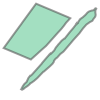

In [13]:
nabe.geometry

Fun, right? But we actually want to **do something** with it. We want to see **which gallery points are inside**. Before we do that, let's think about how searching works.

**Let's say we wanted to find galleries that included "Gallery" in their name.** We'd do something like this:

In [14]:
galleries['name'].str.contains("Gallery").head()

0    False
1     True
2     True
3    False
4    False
Name: name, dtype: bool

**In the same way you can use a dataframe column to search for a string, geopandas lets you do a [lot of geographic stuff](http://geopandas.org/geometric_manipulations.html)** with GeoSeries and GeoDataFrames - find centers, calculate boxes that surrounding shapes, create buffers around things. In this case we're going to use `.within` to say "hey galleries, are you within this neighborhood's geometric shape?"

In [15]:
galleries.within(nabe.geometry).head(20)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17     True
18    False
19    False
dtype: bool

**How many galleries are in that neighborhood?** Well, we could do a `.value_counts()`...

In [16]:
galleries.within(nabe.geometry).value_counts()

False    888
True      29
dtype: int64

...or we could do a `.sum()`, which adds up all of the `True`s for us.

In [17]:
galleries.within(nabe.geometry).sum()

29

**Hooray!** And just like we do every single time we get a list of `True` and `False`, we can also feed it right back into the `galleries` dataframe...

In [18]:
galleries[galleries.within(nabe.geometry)].head()

,name,tel,url,addr1,addr2,city,zip,longitude,latitude,point
17,Pandora Old Masters,(212) 628-1974,http://www.salondudessin.com/an/anpandora.html,212 E 70th St,NaN,New York,10021,-73.960816,40.767892,POINT (-73.96081641000001 40.76789235)
66,Rabenou Yris Ancient Arts,(212) 486-0661,http://www.antiquecollectiblestore.com/detail/...,249 E 61st St,NaN,New York,10021,-73.963836,40.762224,POINT (-73.9638362 40.76222398)
68,Rafael Gallery,(212) 744-8666,http://www.getfave.com/locations/888896-rafael...,241 E 59th St,NaN,New York,10022,-73.964848,40.761069,POINT (-73.96484847000001 40.76106891)
96,Rogallerycom,(212) 732-6887,http://www.auction-directory.info/auction/roga...,300 East 74th Street,NaN,New York,10021,-73.957268,40.769708,POINT (-73.95726809 40.7697075)
98,Roosevelt Island Visual Arts Assoc,(212) 308-6630,http://rivaa.com/,527 Main St,NaN,New York,10044,-73.956435,40.753599,POINT (-73.95643509999999 40.75359867)


And there we go! **All of the galleries that are in Lennox Hill or Roosevelt Island.**

Once we actually want to do the counting, let's go back to where we did that `.sum()` before. **Given a single geometry, we're able to count the galleries inside**.

In [19]:
galleries.within(nabe.geometry).sum()

29

### Step Three: Working with an entire dataframe

The problem is that when we're working with dataframes, we're working with **all of the rows at once**, and we can't just do something like `galleries.within(neighborhoods.geometry).sum()` - instead of comparing **each galleries to every neighborhood**, it just pairs them up - it compares row 1 of the galleries to row 1 of the neighborhoods, row 2 of the galleries to row 2 of the neighborhoods, etc - which we don't like.

We need to do this **to each individual row**. Luckily, we kind of know how to use `.apply`, which executes complicated stuff on each row!

So now we'll say "Hey, each row of the neighborhood - let's take your geometry and let the galleries see if they're inside of it."

**First, here's how to look at each neighborhood's geometry**. We use `.apply` along with `axis=1` to perform something on each row.

In [20]:
neighborhoods.head().apply(lambda row: row.geometry, axis=1)

0    POLYGON ((-73.94732672160579 40.62916656720946...
1    POLYGON ((-73.94193078816194 40.70072523469547...
2    POLYGON ((-73.89138023380261 40.86170058826306...
3    POLYGON ((-73.97604935591414 40.63127590564665...
4    POLYGON ((-73.90855790522767 40.65209593779451...
dtype: object

Now all we need to do is add in the `.within` part we created earlier...

In [21]:
neighborhoods.apply(lambda row: galleries.within(row.geometry).sum(), axis=1)

0        0
1        1
2        0
3        1
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       1
12       0
13       0
14       1
15       0
16       0
17       0
18       0
19       1
20       0
21       0
22       0
23       0
24       0
25      12
26     153
27       0
28       0
29       0
      ... 
165      0
166      0
167      0
168      0
169      0
170      1
171      4
172      0
173      0
174      1
175      0
176      0
177      0
178      2
179      0
180    208
181      6
182      1
183     11
184      1
185      0
186      0
187      3
188      2
189      0
190      0
191      3
192      0
193      0
194      0
Length: 195, dtype: int64

We can add this into our original dataframe easily.

In [22]:
%%time
neighborhoods['gallery_count'] = neighborhoods.apply(lambda row: galleries.within(row.geometry).sum(), axis=1)

CPU times: user 5.99 s, sys: 28.7 ms, total: 6.02 s
Wall time: 6.02 s


See that? Only one line!!! It's slower than the first version, though, and not as flexible. If each gallery had a `score`, getting the median would require something like

    neighborhoods['avg_score'] = neighborhoods.apply(lambda row: galleries[galleries.within(row.geometry)].score.median(), axis=1)

which kind of somewhat isn't as nice.

### Part Five: Mapping

Whew, okay. Whew. If you ran all of the code above, we now have a column for the number of galleries.

In [23]:
neighborhoods.head(2)

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Area,Shape_Leng,geometry,gallery_count
0,3,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,POLYGON ((-73.94732672160579 40.62916656720946...,0
1,3,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,POLYGON ((-73.94193078816194 40.70072523469547...,1


Let's map that. Make it look nice, use a good projection, etc, and pick a [non-default colormap](https://matplotlib.org/examples/color/colormaps_reference.html). I think something under 'sequential' is your best bet.

(-74.283370478149223,
 -73.672229948213371,
 40.47514452610185,
 40.936503645568806)

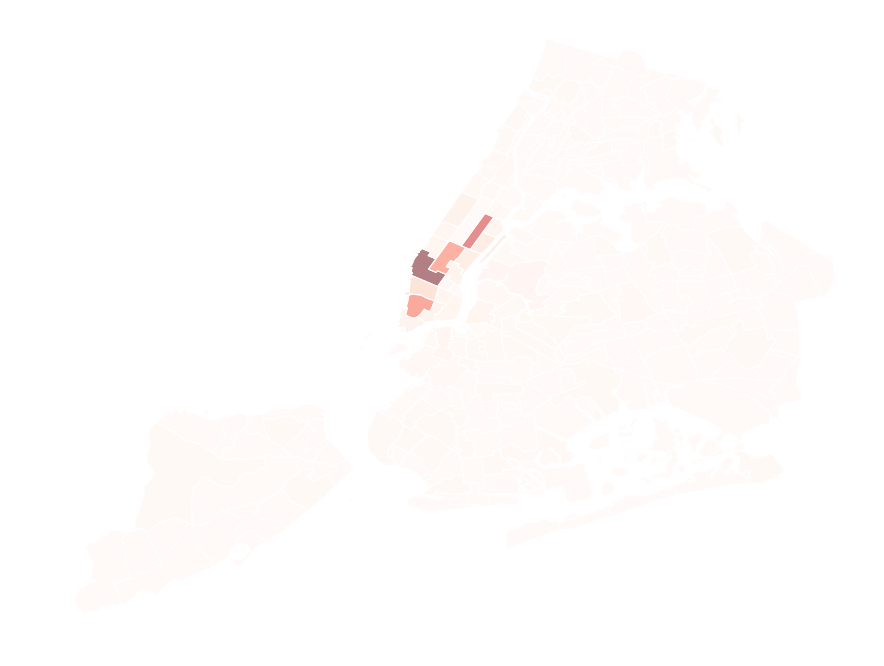

In [88]:
ax = neighborhoods.plot(edgecolor='white', column='gallery_count', cmap='Reds', figsize=(15,15))
ax.axis('off')

# Solo work

You have two datasets:

* A csv of volcanoes in the world, called `volanoes.csv`
* A shapefile of US states, unzipped into `cb_2016_us_state_500k/`

We're going to count the volcanoes in each state, then create a choropleth map of the results.

## Step One: Read in your data

First the volcanoes, then the shapefile.

In [64]:
df = pd.read_csv('volcanoes.csv')
df['geometry'] = df.apply(lambda row: Point(row.LONG, row.LAT), axis=1)
volcanoes = gpd.GeoDataFrame(df, geometry='geometry')
volcanoes.crs = {'init': 'epsg:4326'}

In [66]:
volcanoes.head()

,X,Y,VOLCANX020,NUMBER,NAME,LOCATION,STATUS,ELEV,TYPE,TIMEFRAME,LAT,LONG,geometry
0,120.349998,15.130000,1,0703-083,Pinatubo,Luzon-Philippines,Historical,1486,Stratovolcano,D1,15.130,120.35,POINT (120.35 15.13)
1,120.550003,16.330002,2,0703-086,Santo Tomas,Luzon-Philippines,Uncertain,2260,Stratovolcano,?,16.330,120.55,POINT (120.55 16.33)
2,121.180000,21.830002,3,0801-02=,Unnamed,Taiwan-E of,Historical,-115,Submarine volcano,D3,21.830,121.18,POINT (121.18 21.83)
3,120.400002,14.704999,4,0703-082,Natib,Luzon-Philippines,Holocene?,1287,Stratovolcano,?,14.705,120.40,POINT (120.4 14.705)
4,120.500000,14.500001,5,0703-081,Mariveles,Luzon-Philippines,Radiocarbon,1420,Stratovolcano,D7,14.500,120.50,POINT (120.5 14.5)


In [67]:
states = gpd.read_file('cb_2016_us_state_500k/cb_2016_us_state_500k.shp')

In [68]:
states.head()

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ..."
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ..."


## Step Two: Plot them on top of each other

Just for kicks, so we can see how it looks. Make sure they have the same crs!

In [69]:
states = states.to_crs(volcanoes.crs)

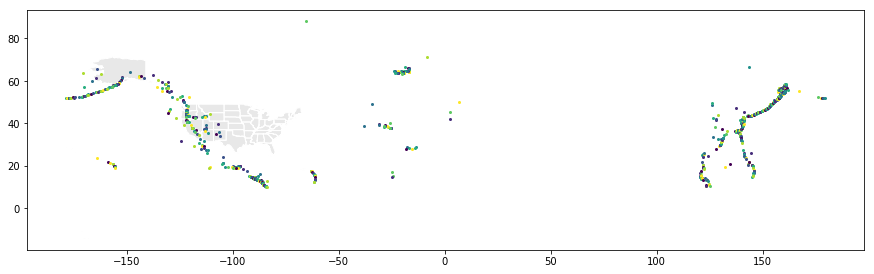

In [72]:
ax = states.plot(color='lightgray', edgecolor='white', figsize=(15,15))
volcanoes.plot(ax=ax)

## Step Three: Spatial join

Join them together, counting the number of volcanoes in each US state. Use the `sjoin` method, and be sure you use `.reset_index()` so you can join them together later.

If the CRS doesn't match, **make the CRS match**.

In [80]:
states_with_volcs = gpd.sjoin(states.reset_index(), volcanoes, how='inner', op='intersects')
states['volcano_count'] = states_with_volcs.index.value_counts()
states['volcano_count'] = states['volcano_count'].fillna(0)
states.head(5)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,volcano_count
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999...",0.0
1,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5...",86.0
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3...",2.0
3,0400000US05,134771517596,2960191698,05,00,Arkansas,05,00068085,AR,"POLYGON ((-94.6178329666013 36.4994141203285, ...",0.0
4,0400000US06,403501101370,20466718403,06,00,California,06,01779778,CA,"(POLYGON ((-118.604415 33.478552, -118.598783 ...",19.0


## Step Four: Map it

Okay, yeah, it'll look terrible, but the future holds great things for you. Just try to shoot for some sort of projection, a reasonable [colormap](https://matplotlib.org/examples/color/colormaps_reference.html), etc. You'll find out a bit more about only mapping part of the world soon.

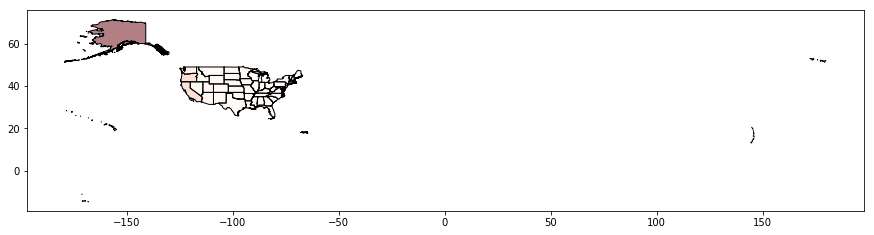

In [87]:
states.plot(figsize=(15,15), column='volcano_count', cmap='Reds')